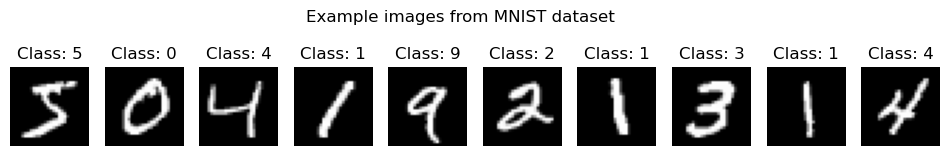

img size: (28,28)


In [1]:
import torch
import numpy as np
from torchvision.transforms import v2, ToPILImage
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.v2.functional as F
from utils import MAE_Encoder, MAE_Decoder
from masking import saliency_guided_masking

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = v2.Compose([v2.PILToTensor()])
# Load MNIST dataset
X_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
X_test = datasets.MNIST('../data', train=False, download=True, transform=transform)

# Visualize some samples
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    input, classes = X_train[i]
    plt.imshow(input.squeeze(), cmap="gray")
    plt.title(f"Class: {classes}")
    plt.axis("off")

plt.suptitle("Example images from MNIST dataset")
plt.show()

img_size = 28
patch_size = 4
print(f"img size: ({img_size},{img_size})")

def extract_patches(img, patch_size):
    imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
    return imgp

# Returns a tensor of size [batch_size, num_patches, patch_size, patch_size]
def collate_fn(batch):
    images, _ = zip(*batch)
    imgs = np.array([np.asarray(image) for image in images]) / 255.0
    imgs = torch.tensor(imgs, dtype=torch.float32)
    imgs_orig = imgs.clone().reshape(imgs.shape[0], -1)
    imgs = torch.cat([extract_patches(img, patch_size) for img in imgs], dim=1)
    imgs = imgs.permute(1, 0, 2, 3)
    return imgs, imgs_orig.reshape(-1, 1, 28, 28)

# DataLoader creation
batch_size = 16
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [2]:
# Get random sample
sample = next(iter(test_loader))
img, img_orig = sample
encoder = MAE_Encoder(img_size=img_size, mask_ratio=0.75)
decoder = MAE_Decoder(img_size=img_size)

print(img_orig.shape)
encoded, backward_indexes = encoder(img_orig)
dec_img, mask = decoder(encoded, backward_indexes)

torch.Size([16, 1, 28, 28])


torch.Size([49, 16])
torch.Size([13, 16, 192])
torch.Size([49, 16, 192])

torch.Size([16, 49, 49])
torch.Size([16, 49, 49])
torch.Size([16, 49, 49])
tensor(0.6677)
torch.Size([16, 16, 192])


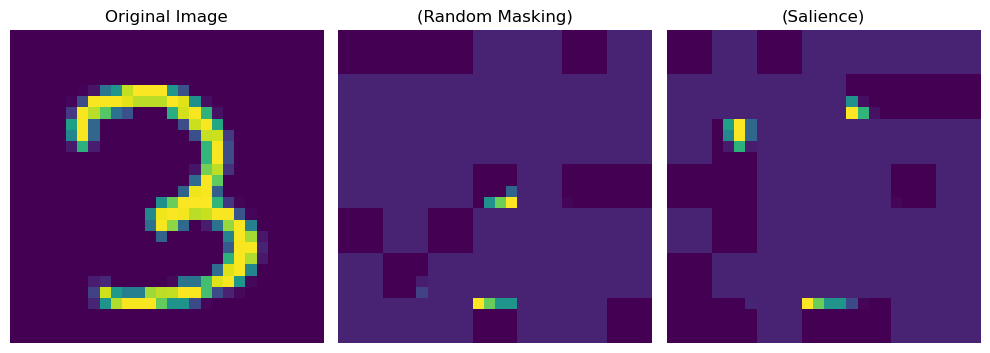

In [3]:
from einops import repeat, rearrange
from einops.layers.torch import Rearrange


print(backward_indexes.shape)
print(encoded.shape)
# Random masking
masked_im = img_orig[0, 0].clone()  
masked_im[mask[0, 0] != 0] = 0.1

base_masking = 0.75
mask_ratio_var = 0.15
delta = 0.1

patches = encoder.patch_embed(img_orig)
print(patches.shape, end="\n\n")   

x, mask, ids_restore = saliency_guided_masking(patches, base_masking, mask_ratio_var, delta)

encoded = rearrange(x, 't b e -> b t e')
ids_restore = rearrange(ids_restore, 'b t -> t b')
print(x.shape)

dec_img, mask = decoder(encoded, ids_restore)
masked_im2 = img_orig[0, 0].clone()
masked_im2[mask[0, 0] != 0] = 0.1


# Plot the original and masked images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_orig[0][0])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(masked_im)
plt.title("(Random Masking)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(masked_im2)
plt.title("(Salience)")
plt.axis("off")

# Add spacing between the plots for better readability
plt.tight_layout()
plt.show()

# Plankton images

In [4]:
import torch
from torchvision.transforms import v2
import torch.nn as nn
from pathlib import Path
import random
from PIL import Image, ImageFilter
import numpy as np

class TrainTestTransforms(nn.Module):
    def __init__(self, img_size=256, crop_size=224, mean=0.5, std=0.5):
        """
        Args:
            img_size (int): Target size for resizing the image.
            crop_size (int): Target size for cropping the image.
            mean (float): Mean for normalization.
            std (float): Standard deviation for normalization.
            noise_params (dict): Parameters for GaussianNoise.
            blur_params (dict): Parameters for GaussianBlur.
        """
        super(TrainTestTransforms, self).__init__()
        
        
        self.img_size = img_size
        self.crop_size = crop_size
        self.mean = mean
        self.std = std
        
        # Define common preprocessing steps
        self.to_tensor = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

    def forward(self, img):
        img = img.convert("L")
        fill_color = img.getpixel((0, 0))  # Get fill color from top-left pixel for affine transform
        # Define transforms
        if self.training:
            transform_list = [
                v2.Resize((self.img_size, self.img_size)),
                v2.Grayscale(num_output_channels=1),
                v2.RandomAffine(degrees=(-180, 180),  scale=(0.5, 1.2), fill=fill_color),
                v2.RandomResizedCrop((self.crop_size, self.crop_size), scale=(0.3, 1), interpolation=3),
                v2.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1)),
                self.to_tensor,
                # v2.GaussianNoise(0, 0.01),
                # v2.GaussianBlur(3, 2),
                v2.Normalize(mean=[self.mean], std=[self.std])
            ]
        else:
            transform_list = [
                v2.Resize((self.img_size, self.img_size)),
                v2.Grayscale(num_output_channels=1),
                v2.CenterCrop((self.crop_size, self.crop_size)),
                v2.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1)),
                self.to_tensor,
                v2.Normalize(mean=[self.mean], std=[self.std])
            ]

        # Compose and apply the transform
        transform = v2.Compose(transform_list)
        return transform(img)

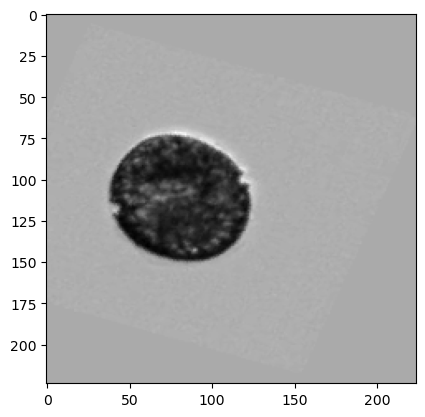

In [5]:
from PIL import Image
from torchvision.datasets import ImageFolder

transform = TrainTestTransforms(img_size=256).train()

plankton_dataset = ImageFolder("./data/", transform=transform)
train_loader = torch.utils.data.DataLoader(plankton_dataset, batch_size=5, shuffle=True, num_workers=2)

# Get random image
sample = next(iter(train_loader))
img, label = sample

plt.imshow(img[0, 0], cmap="gray")
plt.show()

In [ ]:
import torch
import torch.nn as nn
from einops import repeat, rearrange
from masking import saliency_guided_masking



mask_ratio=0.5
mask_ratio_var = 0.35
delta = 0.05
sample = next(iter(train_loader))
img, label = sample

plt.figure(figsize=(6,15))
for i in range(10):
    encoder = MAE_Encoder(img_size=224, patch_size=16,  mask_ratio=mask_ratio)
    decoder = MAE_Decoder(img_size=224, patch_size=16)
    
    patches = encoder.patch_embed(img)

    # Random masking
    encoded, forward_indexes, backward_indexes = encoder.shuffle(patches)
    dec_img, mask = decoder(encoded, backward_indexes)

    masked_im = img[0, 0].clone()  
    masked_im[mask[0, 0] != 0] = 0.1

    # Salience masking
    encoded, ids_restore = saliency_guided_masking(patches, mask_ratio, mask_ratio_var, delta)
    dec_img, mask2 = decoder(encoded, ids_restore)

    masked_im2 = img[0, 0].clone()  
    masked_im2[mask2[0, 0] != 0] = 0.1

    plt.subplot(10, 3, (3*i)+1)
    plt.imshow(img[0][0], cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(10, 3, (3*i)+2)
    plt.imshow(masked_im, cmap="gray")
    plt.title("Random masked")
    plt.axis("off")
    plt.subplot(10, 3, (3*i)+3)
    plt.imshow(masked_im2, cmap="gray")
    plt.title("Salience masked")
    plt.axis("off")
plt.show()

torch.Size([5, 196, 196])
torch.Size([5, 196, 196])
torch.Size([5, 196, 196])
tensor(0.7321)


ValueError: too many values to unpack (expected 2)

<Figure size 600x1500 with 0 Axes>

In [7]:
(224/16)*(224/16)

196.0